**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
  - 1.1. [Model class](#toc1_1_)    
- 2. [Illustrating the pareto improving set $\mathcal{C}$ in an Edgeworth box](#toc2_)    
- 3. [Calculate error in market clearing condition](#toc3_)    
- 4. [Assuming that A chooses the price:](#toc4_)    
  - 4.1. [Find the allocation if only prices in $\mathcal{P_1}$ can be chosen](#toc4_1_)    
  - 4.2. [Find the allocation if any positive price can be chosen:](#toc4_2_)    
- 5. [Assuming A chooses B's consumption](#toc5_)    
  - 5.1. [Find the allocation if the choice set is restricted to $\mathcal{C}$ and B is not worse off than his/her endowment](#toc5_1_)    
  - 5.2. [Find the allocation if no further restrictions are imposed](#toc5_2_)    
- 6. [Assuming a social planner allocation maximizes aggregate utility](#toc6_)    
  - 6.1. [Find the resulting allocation:](#toc6_1_)    
  - 6.2. [Round up](#toc6_2_)    
- 7. [Drawing a random set $\mathcal{W}$](#toc7_)    
  - 7.1. [Find the market equilibrium for each $\mathcal{W}^A \in \mathcal{C}$](#toc7_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Imports](#toc0_)

In [1]:
import matplotlib.pyplot as plt

# Use latex rendering for nice plot
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "black",
    "grid.alpha": "0.25",
    "grid.linestyle": "--",
    "font.size": 14,
})


%load_ext autoreload
%autoreload 2

import pandas as pd
import polars as pl

import numpy as np
# Set seed number
np.random.seed(404)
from scipy import optimize

### 1.1. <a id='toc1_1_'></a>[Model class](#toc0_)

In [2]:
from ExchangeEconomy import ExchangeEconomyClass

# Import model class
model = ExchangeEconomyClass()

# Print initial model settings
print(f'Initial endowment for A: {model.w1A, model.w2A}.\nInitial endowment for B: {1-model.w1A, 1-model.w2A}.\n**Parameters**\nAlpha={model.alpha}, Beta={model.beta}')

Initial endowment for A: (0.8, 0.3).
Initial endowment for B: (0.19999999999999996, 0.7).
**Parameters**
Alpha=0.3333333333333333, Beta=0.6666666666666666


## 2. <a id='toc2_'></a>[Illustrating the pareto improving set $\mathcal{C}$ in an Edgeworth box](#toc0_)

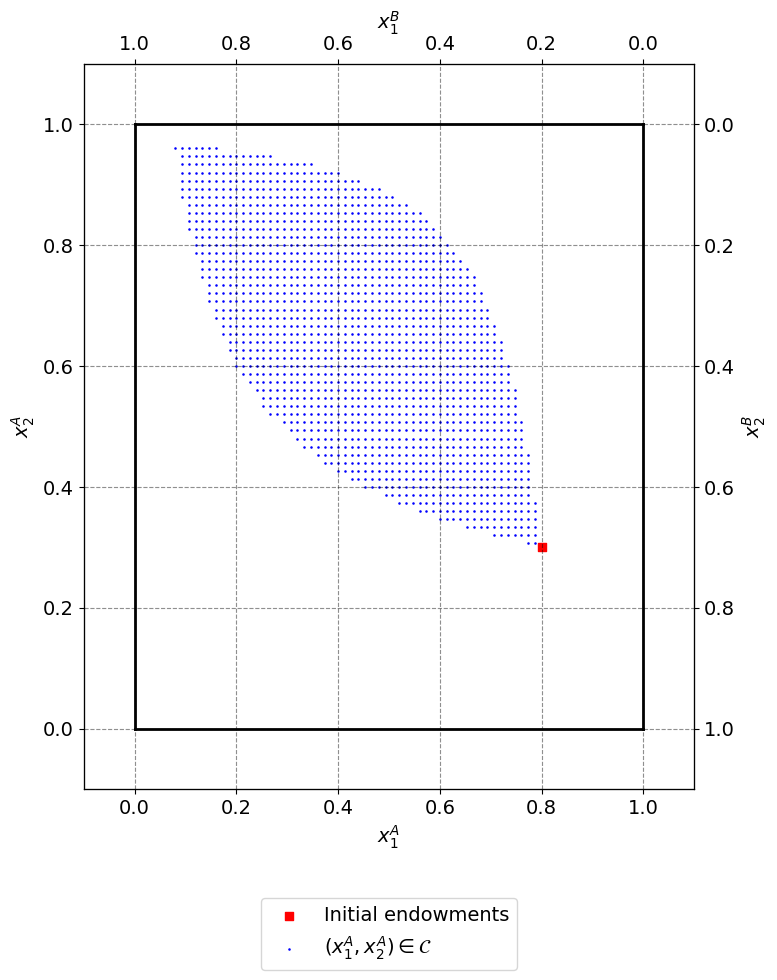

In [3]:

# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig_A,ax_A = plt.subplots(figsize=(8,10),tight_layout=True)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(model.w1A,model.w2A,marker='s',color='r',label='Initial endowments')

# Initial endowments
omega_a1 = model.w1A
omega_a2 = model.w2A
omega_b1 = 1-model.w1A
omega_b2 = 1-model.w2A

# Generate point grids
N = 75
x_a1 = np.linspace(0,1,N+1)
x_a2 = np.linspace(0,1,N+1)

# Define the set C
C = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_A(xA1, xA2) >= model.utility_A(omega_a1, omega_a2) 
    and model.utility_B(1 - xA1, 1 - xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Plot C
ax_A.scatter([point[0] for point in C], [point[1] for point in C], marker='o', color='b', label=r'$(x_1^A, x_2^A) \in \mathcal{C}$', s=0.7)

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

legend = ax_A.legend(loc='center',bbox_to_anchor=(.5,-.2))

## 3. <a id='toc3_'></a>[Calculate error in market clearing condition](#toc0_)

We can of course analytically solve for the price, setting $p_2$ as numeraire:

\begin{aligned}
x_1^{A *}\left(p_1, \omega^A\right)+x_1^{B *}\left(p_1, \omega^B\right)&=\omega_1^A + \omega_1^B \Leftrightarrow \\
\alpha \frac{p_1 w_1^A+w_2^A}{p_1}+\beta \frac{p_1 w_1^A+w_2^B}{p_1}&=1 \Leftrightarrow \\
p_1\left(1-\alpha w_1^A-\beta w_1^B\right)&=\alpha w_2^A+\beta w_2^B \Leftrightarrow \\
p_1^*&=\frac{(\alpha w_2^A+\beta w_2^B)}{1-\alpha w_1^A-\beta w_1^B} \\
p_1^*&=\frac{(\alpha-\beta)w_2^A+\beta}{1-(\alpha-\beta)\omega_1^A-\beta}
\end{aligned}


In [4]:
# Define our price vector P_1
P_1 = np.linspace(0.5,2.5,N+1)

# Find market clearing errors
eps_1,eps_2=model.market_clear_err(P_1)

# Find market clearing price
p_star_num=model.market_clear_price(P_1)

# We can do this analytically as well
alpha = model.alpha
beta = model.beta
w1A=model.w1A
w2A=model.w2A

p_star_exact = ((alpha-beta)*w2A+beta)/(1-(alpha-beta)*w1A-beta)

Market clearing price p_1 in P_1 is 0.9533333333333334. Exact solution: 0.9444444444444444.


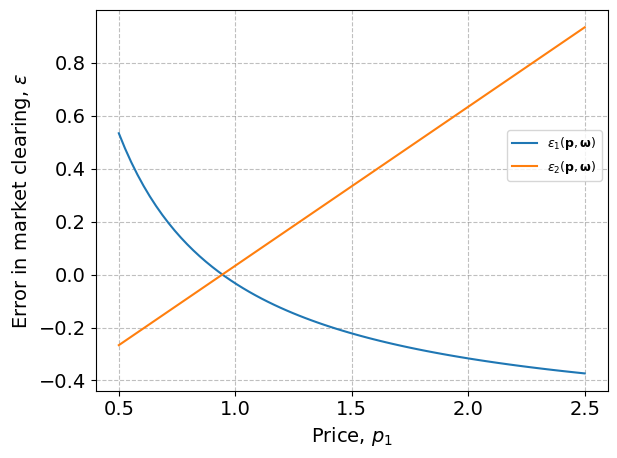

In [5]:
fig,ax = plt.subplots(tight_layout=True)
ax.plot(P_1, eps_1, label=r'$\epsilon_1(\mathbf{p}, \mathbf{\omega})$')
ax.plot(P_1, eps_2, label=r'$\epsilon_2(\mathbf{p}, \mathbf{\omega})$')
ax.set_ylabel(r'Error in market clearing, $\epsilon$')
ax.set_xlabel(r'Price, $p_1$')
ax.legend(loc='upper right', bbox_to_anchor=(1,.7), fontsize=9)
print(f'Market clearing price p_1 in P_1 is {p_star_num}. Exact solution: {p_star_exact}.')

## 4. <a id='toc4_'></a>[Assuming that A chooses the price:](#toc0_)
### 4.1. <a id='toc4_1_'></a>[Find the allocation if only prices in $\mathcal{P_1}$ can be chosen](#toc0_)

In [6]:
# Price vector
P_1 = np.linspace(0.5,2.5,N+1)

## Define objective function
def obj_max_U(p1):
    x_b1, x_b2=model.demand_B(p1)
    return -model.utility_A(1-x_b1, 1-x_b2)

# Get me a random pair of p from P_1
id_rand=np.random.randint(0,N)
guess=P_1[id_rand]

# Bounds defined as belonging to P
bounds = [(P_1.min(), P_1.max())]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess, bounds=bounds)

# Price that maximizes utility for A
price_util_max_a=res.x[0]
utility_val_A=-res.fun

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
utility_val_B_4a=model.utility_B(x_b1_opt,x_b2_opt)

x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_4a=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['4a']).round(3)
df_4a

,X1A,X2A,X1B,X2B,Agg. util
4a,0.621,0.64,0.379,0.36,1.006


### 4.2. <a id='toc4_2_'></a>[Find the allocation if any positive price can be chosen:](#toc0_)

In [7]:
# Bounds now positive
bounds = [(0, None)]

## Define objective function
def obj_max_U(p1):
    x_b1, x_b2=model.demand_B(p1)
    return -model.utility_A(1-x_b1, 1-x_b2)

## Guess p from P_1
guess=P_1[id_rand]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess, bounds=bounds)

# Price that maximizes utility for A
price_util_max_a=res.x[0]
utility_val_A=-res.fun

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt


# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_4b=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['4b']).round(3)
df_4b

,X1A,X2A,X1B,X2B,Agg. util
4b,0.621,0.64,0.379,0.36,1.006


We notice that this is the same price!

---

## 5. <a id='toc5_'></a>[Assuming A chooses B's consumption](#toc0_)
### 5.1. <a id='toc5_1_'></a>[Find the allocation if the choice set is restricted to $\mathcal{C}$ and B is not worse off than his/her endowment](#toc0_)

In [8]:
# Define the bounds from C
x_a1_min = min([point[0] for point in C])
x_a1_max = max([point[0] for point in C])
x_a2_min = min([point[1] for point in C])
x_a2_max = max([point[1] for point in C])

# Objective func 
def obj_max_U(X):
    return -model.utility_A(X[0], X[1])

# Inequality constraints are generally on the form: x-y>=0 in scipy.optimize.minimize
# https://kitchingroup.cheme.cmu.edu/f19-06623/13-constrained-optimization.html

def constraint1(x):
    return model.utility_B(1 - x[0], 1 - x[1]) - model.utility_B(1-model.w1A, 1-model.w2A)
def constraint2(x):
    return model.utility_A(x[0], x[1]) - model.utility_A(model.w1A, model.w2A)

constraints = [{'type': 'eq', 'fun': constraint1},
               {'type': 'eq', 'fun': constraint2}]

# Get me a random pair of xa1s and xa2s from C
id_rand=np.random.randint(0,N)
guess=C[id_rand]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess,bounds=((x_a1_min,x_a1_max), (x_a2_min,x_a2_max)), constraints=constraints)

# Demand that maximizes As utility
x_a1_opt,x_a2_opt=res.x
utility_val_A=-res.fun

# Corresponding allocation
x_b1_opt = 1-x_a1_opt
x_b2_opt = 1-x_a2_opt

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up'
df_5a=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['5a']).round(3)
df_5a


,X1A,X2A,X1B,X2B,Agg. util
5a,0.08,0.96,0.92,0.04,0.743


### 5.2. <a id='toc5_2_'></a>[Find the allocation if no further restrictions are imposed](#toc0_)

In [9]:
# Generate point grids
N = 75
x_a1 = np.linspace(0,1,N+1)
x_a2 = np.linspace(0,1,N+1)

In [10]:
# Making sure that B's utility is not lower than in the initial endowment
def constraint(x):
    return model.utility_B(1 - x[0], 1 - x[1]) - model.utility_B(1-model.w1A, 1-model.w2A)

# Redefine objective function
def obj_max_U(x):
    return -model.utility_A(x[0], x[1])

# Bounds within 0,1
bounds = [(0,1),(0,1)]

# Get me a random pair of xa1s and xa2s from C
id_rand=np.random.randint(0,N)
guess=C[id_rand]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess, bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})

# Demand that maximizes As utility
x_a1_opt,x_a2_opt=res.x
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt = 1-x_a1_opt
x_b2_opt = 1-x_a2_opt

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_5b=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['5b']).round(3)
df_5b


,X1A,X2A,X1B,X2B,Agg. util
5b,0.001,0.972,0.999,0.028,0.402


## 6. <a id='toc6_'></a>[Assuming a social planner allocation maximizes aggregate utility](#toc0_)
### 6.1. <a id='toc6_1_'></a>[Find the resulting allocation:](#toc0_)

In [11]:
# Define the set D
D = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_B(1-xA1, 1-xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Redefine objective function
def obj_max_U(x):
    return -(model.utility_A(x[0], x[1]) + model.utility_B(1-x[0], 1-x[1]))

# Get me a random pair of xa1s and xa2s from D
id_rand=np.random.randint(0,N)
guess=D[id_rand]

# Bounds of demand
bounds=((0,1), (0,1))

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess,bounds=bounds)

# Demand that maximizes As utility
x_a1_opt,x_a2_opt=res.x
utility_val_A=-res.fun

# Corresponding allocation
x_b1_opt = 1-x_a1_opt
x_b2_opt = 1-x_a2_opt

# Agg utility
utility_val_B = model.utility_B(x_b1_opt, x_b2_opt)
total_util = utility_val_A+utility_val_B

# Summing up
df_6a=pd.DataFrame({
    'X1A':x_a1_opt, 'X2A': x_a2_opt, 
    'X1B':x_b1_opt, 'X2B':x_b2_opt, 
    'Agg. util':total_util
}, index=['6a']).round(3)
df_6a

,X1A,X2A,X1B,X2B,Agg. util
6a,0.333,0.667,0.667,0.333,1.587


### 6.2. <a id='toc6_2_'></a>[Round up](#toc0_)

In [12]:
# Let's see all solutions
tab_out=pd.concat([df_4a, df_4b, df_5a, df_5b, df_6a])
tab_out

,X1A,X2A,X1B,X2B,Agg. util
4a,0.621,0.640,0.379,0.360,1.006
4b,0.621,0.640,0.379,0.360,1.006
5a,0.080,0.960,0.920,0.040,0.743
5b,0.001,0.972,0.999,0.028,0.402
6a,0.333,0.667,0.667,0.333,1.587



Below, I plot all solutions in the Edgeworth box.

**Summary**

The first part (4b) highlights that markets may or may not distort aggregate utility and provide pareto improvidements based purely on market mechanisms.

If A still has market power and can choose any allocation conditional on B not being worse off from his/her endowments (5b), then this yields the lowest aggregate utility. This is because A will consume all $x_1^A$ and no $x_2^A$ and so is *not* a pareto improvement relative to his/her endowment,. 

If A has market power, and is restricted to $\mathcal{C}$, then this yields the slightly higher aggregate utility.

Finally, it is clear that the socially optimal, of course, has the highest aggregate utility!

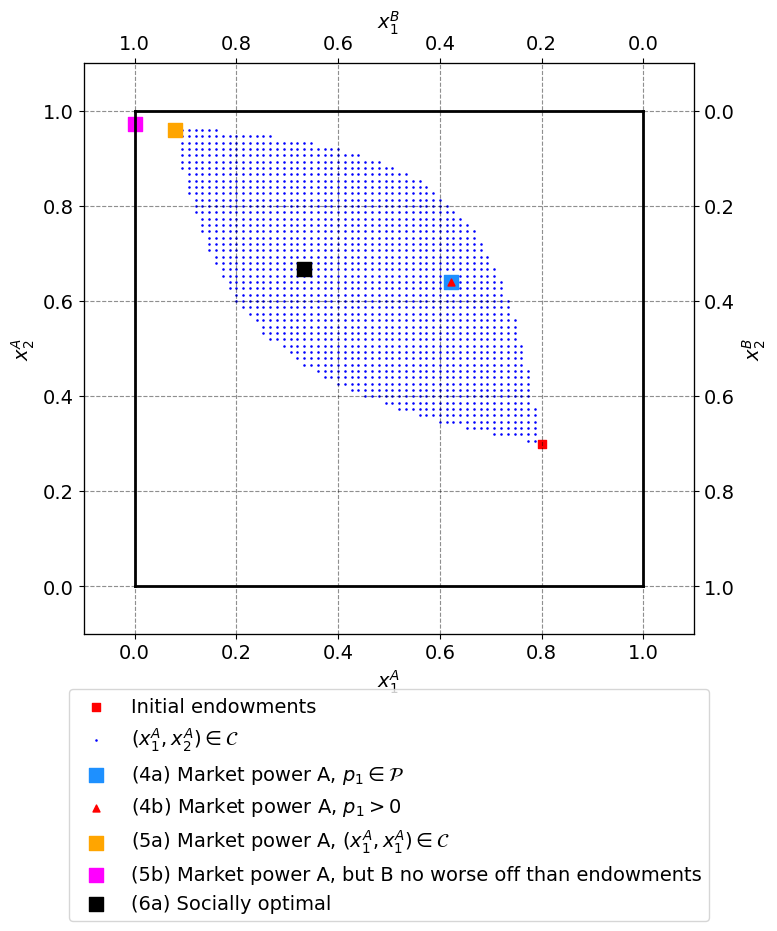

In [13]:
# Get all solutions and draw them in the Edgeworth box
x1a_4a, x2a_4a=tab_out[['X1A', 'X2A']].loc['4a']
x1a_4b, x2a_4b=tab_out[['X1A', 'X2A']].loc['4b']

x1a_5a, x2a_5a=tab_out[['X1A', 'X2A']].loc['5a']
x1a_5b, x2a_5b=tab_out[['X1A', 'X2A']].loc['5b']

x1a_6a, x2a_6a =tab_out[['X1A', 'X2A']].loc['6a']

# Drawed in the Edgeworth box
ax_A.scatter(x1a_4a, x2a_4a, marker='s', color='dodgerblue',label=r'(4a) Market power A, $p_1 \in \mathcal{P}$',s=100)
ax_A.scatter(x1a_4b, x2a_4b, marker='^', color='red',label=r'(4b) Market power A, $p_1>0$',s=25)

ax_A.scatter(x1a_5a, x2a_5a, marker='s', color='orange',label=r'(5a) Market power A, $(x_1^A, x_1^A) \in \mathcal{C}$',s=100)
ax_A.scatter(x1a_5b, x2a_5b, marker='s', color='magenta',label=r'(5b) Market power A, but B no worse off than endowments',s=100)

ax_A.scatter(x1a_6a, x2a_6a, marker='s', color='black',label=r'(6a) Socially optimal',s=100)

# I am sorry to anyone colorblind
legend = ax_A.legend(loc='center', bbox_to_anchor=(.5,-.3))
fig_A

## 7. <a id='toc7_'></a>[Drawing a random set $\mathcal{W}$](#toc0_)
### 7.1. <a id='toc7_1_'></a>[Find the market equilibrium for each $\mathcal{W}^A \in \mathcal{C}$](#toc0_)

In [14]:
# Defining the set as W, assumning that it is drawn from uniform distribution
N = 50
omega_1a = np.random.uniform(0,1,N)
omega_2a = np.random.uniform(0,1,N)

W = [
    (om1a, om2a) 
    for om1a in omega_1a
    for om2a in omega_2a
]

In [15]:
# Model instantiate
model=ExchangeEconomyClass()

# Save initial endowments
omega_a1_init  = model.w1A
omega_a2_init = model.w2A

omega_b1_init = 1-model.w1A
omega_b2_init = 1-model.w2A

# My demands to be plotted in Edgeworth box, within or outside C (little unsure what is meant with that last question)
## Numerically
x1as_num = []
x2as_num = []
x1as_num_out = []
x2as_num_out = []

## Analytically
x1as_exact = []
x2as_exact = []
x1as_exact_out = []
x2as_exact_out = []

# Define some price vector
P = np.linspace(0.1,20,100)

# For each endowment pair in W
for om1a,om2a in W:

    # Change model params
    model.w1A=om1a
    model.w2A=om2a

    # Find clearing price numerically
    p_star = model.market_clear_price(P)

    # We can do this analytically as well
    alpha = model.alpha
    beta = model.beta
    
    p_star_exact = ((alpha-beta)*om2a+beta)/(1-(alpha-beta)*om1a-beta)

    # corresponding demands
    x1a,x2a = model.demand_A(p_star)
    x1a_exact,x2a_exact = model.demand_A(p_star_exact)

    # Within C or not?
    ## Numerically
    if model.utility_A(x1a, x2a) >= model.utility_A(omega_a1_init, omega_a2_init) and \
    model.utility_B(1 - x1a, 1 - x2a) >= model.utility_B(omega_b1_init, omega_b2_init):

    # If true, proceed
        x1as_num.append(x1a)
        x2as_num.append(x2a)
    
    else:
    # If not then, plot them outside C (not pareto improving)
        x1as_num_out.append(x1a)
        x2as_num_out.append(x2a)

    
    # Within C or not?
    ## Analytically
    if model.utility_A(x1a_exact, x2a_exact) >= model.utility_A(omega_a1_init, omega_a2_init) and \
    model.utility_B(1 - x1a_exact, 1 - x2a_exact) >= model.utility_B(omega_b1_init, omega_b2_init):

    # If true, proceed
        x1as_exact.append(x1a_exact)
        x2as_exact.append(x2a_exact)
    
    else:
    # If not then, plot them outside C (not pareto improving)
        x1as_exact_out.append(x1a_exact)
        x2as_exact_out.append(x2a_exact)

c:\Users\JBH\Dropbox\12_semester\IntroToProg\projects-2024-jbh\inauguralproject\ExchangeEconomy.py:59: RuntimeWarning: invalid value encountered in scalar power
  util = x1B**beta * x2B**(1 - beta)


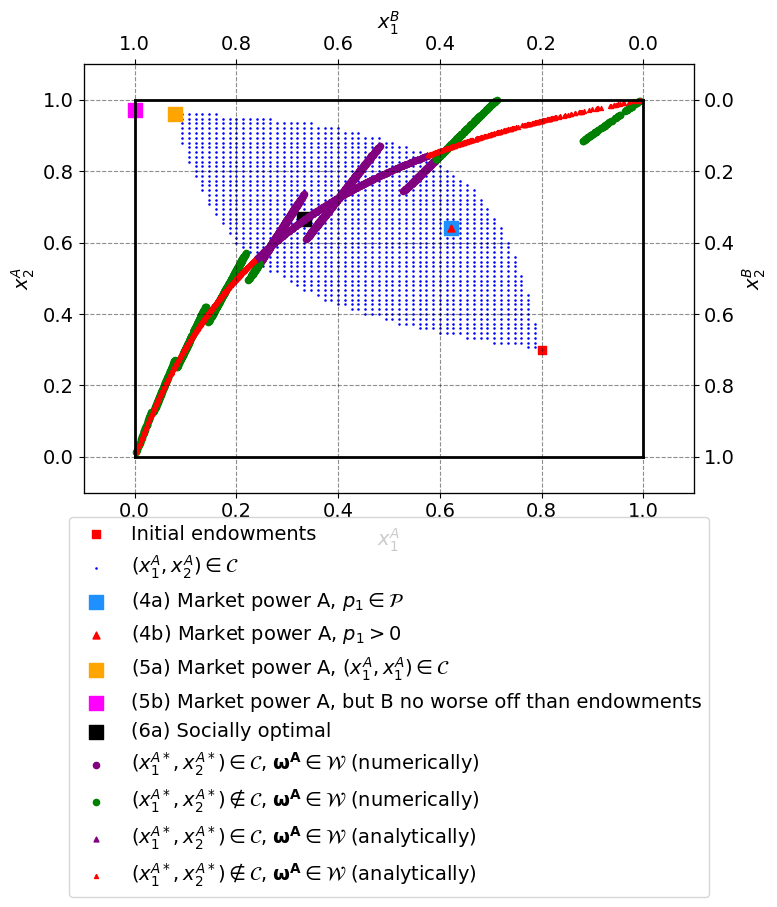

In [16]:
# Plot our results 

# First numerically
ax_A.scatter(x1as_num, x2as_num, marker='o', color='purple', label=r'$(x_1^{A*}, x_2^{A*}) \in \mathcal{C}$, $\mathbf{\omega^A} \in \mathcal{W}$ (numerically)', s=20)
ax_A.scatter(x1as_num_out, x2as_num_out, marker='o', color='green', label=r'$(x_1^{A*}, x_2^{A*}) \notin \mathcal{C}$, $\mathbf{\omega^A} \in \mathcal{W}$ (numerically)', s=20)

# Then analytical results
ax_A.scatter(x1as_exact, x2as_exact,marker='^', color='purple', label=r'$(x_1^{A*}, x_2^{A*}) \in \mathcal{C}$, $\mathbf{\omega^A} \in \mathcal{W}$ (analytically)',s=12, zorder=1)
ax_A.scatter(x1as_exact_out, x2as_exact_out, marker='^', color='red', label=r'$(x_1^{A*}, x_2^{A*}) \notin \mathcal{C}$, $\mathbf{\omega^A} \in \mathcal{W}$ (analytically)', s=8, zorder=1)

legend = ax_A.legend(loc='center', bbox_to_anchor=(.5,-.5))
fig_A

**Final thoughts**

We notice that "randomizing" endowments drawn from a uniform distribution may lead market equilibriums to 1) fall outside C, and thus *not* be a pareto improvement compared to our initial endowments 2) lead to a pareto improvements over initial endowments (purple dots) 3) be socially optimal (black square) simply by "chance". 

Further, the figure highilights the imprecision one might encounter when optimizing functions/economic problems. In this case, we can derive the exact solution for the market clearing price. However, if we optimize on a vector of different discrete prices, the solutions may diverge and look like discontinuities. 